In [2]:
import pandas as pd
import json
import os
import argparse
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import nltk
import numpy as np

def load_json_file(file_path):
    """Load JSON file and return as Python object"""
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            return json.load(f)
    except Exception as e:
        print(f"Error loading {file_path}: {str(e)}")
        return None

def extract_video_name(path):
    """Extract video filename without extension from path"""
    return os.path.splitext(os.path.basename(path))[0]

In [13]:
prediction_path = 'output/batch_video_results.json'
references_path = 'datasets/video_prompts.json'
#output_path = 'output/batch_video_results.csv'


# Load JSON files
predictions_data = load_json_file(prediction_path)
references_data = load_json_file(references_path)

if not predictions_data or not references_data:
    print("Failed to load one or both JSON files. Exiting.")

# Create a dictionary of reference prompts keyed by video name
reference_dict = {}
for item in references_data:
    # Adapt this according to your reference JSON structure
    if isinstance(item, dict) and 'video' in item and 'conversations' in item:
        reference_dict[item['video']] = item['conversations'][1]['value']


# Create a list to store all comparison data
comparison_data = []

# Process each prediction
for pred in predictions_data:
    video_name = pred['video_name']
    prediction = pred.get('prediction', '')
    
    # Find matching reference
    reference = reference_dict.get(video_name, '')
    
    
    # Add to comparison data
    comparison_data.append({
        'video_name': video_name,
        'reference': reference,
        'prediction': prediction,
    })

# Convert to DataFrame
df = pd.DataFrame(comparison_data)





In [19]:
#Save to CSV
df.to_parquet('output/compare_evalutaion_results.parquet', index=False)


In [1]:
import pandas as pd

result_df = pd.read_parquet('output/compare_evalutaion_results.parquet')

In [2]:
result_df.head()

,video_name,reference,prediction
0,cog-0010fb2b-f6cd-51af-a0b6-b38812f965ea.mp4,The beautiful woman ，under the starry sky ，loo...,a woman with long hair and a white dress
1,cog-001777d8-0130-5a50-8792-a6b46e02df6d.mp4,a futuristic city full of robots walking throu...,a robot running on the street
2,cog-001e551e-961d-5645-9d84-604bc820bbb7.mp4,computer screen capture of surveillance applic...,The video is shot from the inside of a building.
3,cog-001ead14-07ea-592e-bf94-b32c29bd3692.mp4,"las palmeras se mueven, el oc&#233;ano se muev...",light up the palm trees at night
4,cog-001fd7f2-1b04-5749-b4cc-0469eae5d144.mp4,"a girl shooting ,in the 1990s moives",a girl with pink flowers in her hair


In [13]:
from datasets import load_metric
from nltk.tokenize import word_tokenize
from bert_score import score
from nltk.translate.meteor_score import meteor_score
import evaluate
import pandas as pd
import numpy as np
import torch

def Calmetic(references:list[list[str]], predictions:list[str]):
    '''
    Input format:

    predictions = [
        "What is the capital of France?",
        "Who wrote the book?",
        "What is the largest planet?"
    ]

    references = [
        ["What is the capital city of France?"],
        ["Who is the author of the book?"],
        ["Which planet is the largest in the solar system?"]
    ]
    '''

    # # 加载 BLEU 评分器
    # bleu_metric = load_metric("bleu")

    # # 计算 BLEU 分数
    predictions_tokenized = [word_tokenize(pred) for pred in predictions]
    references_tokenized = [[word_tokenize(refs[0])] for refs in references]
    # B_S = {}
    # for n in range(1, 5):
    #     bleu_metric.add_batch(predictions=predictions_tokenized, references=references_tokenized)
    #     results = bleu_metric.compute(max_order=n)
    #     B_S[f"BLEU-{n}"] = results
    bleu_metric = evaluate.load("bleu")
    B_S = bleu_metric.compute(predictions=predictions, references=references,tokenizer=word_tokenize)
    for i,n in enumerate(B_S['precisions']):
        print(f"BLEU-{i+1} score: {n:.5f}")
        


    # 加载 ROUGE 评分器
    rouge_metric = load_metric("rouge")
    '''
    ROUGE-1: 衡量生成文本和参考文本之间的 unigram 匹配。
    ROUGE-2: 衡量生成文本和参考文本之间的 bigram 匹配。
    ROUGE-L: 衡量生成文本和参考文本之间的最长公共子序列(LCS)。
    ROUGE-Lsum: 基于 LCS 的一个变体，专门用于长文本的评估。
    '''
    # 计算 ROUGE 分数
    rouge_results = rouge_metric.compute(predictions=predictions, references=references)
    rouge1_mid_f1 = rouge_results['rouge1'][1][2]
    rouge2_mid_f1 = rouge_results['rouge2'][1][2]
    rougeL_mid_f1 = rouge_results['rougeL'][1][2]
    rougeLsum_mid_f1 = rouge_results['rougeLsum'][1][2]
    print(f"ROUGE-1 F1 score: {rouge1_mid_f1:.5f}")
    print(f"ROUGE-2 F1 score: {rouge2_mid_f1:.5f}")
    print(f"ROUGE-L F1 score: {rougeL_mid_f1:.5f}")
    print(f"ROUGE-Lsum F1 score: {rougeLsum_mid_f1:.5f}")

    # 计算 METEOR 分数
    meteor_scores = [meteor_score(references=refs, hypothesis=pred) for pred, refs in zip(predictions_tokenized, references_tokenized)]
    average_meteor_score = sum(meteor_scores) / len(meteor_scores)
    print(f"Average METEOR score: {average_meteor_score:.5f}")

    # 计算 BERTScore 分数
    '''
    同样效果：
    bert_metric = load_metric("bertscore",cache_dir="/media/fenghe/New Volume/A2Q/Metric")
    bert_results = bert_metric.compute(predictions=predictions, references=references,lang="en",device=f"cuda:{torch.cuda.device_count() - 1}")

    设置 verbose=True 会使函数在计算过程中输出更多的信息，例如处理进度、当前正在处理的数据等。
    '''
    P, R, F1 = score(predictions, [ref[0] for ref in references], lang="en", verbose=False)
    average_bert_score = F1.mean().item()
    print(f"Average BERTScore F1: {average_bert_score:.5f}")

    return {
        "BLEU":B_S,
        "ROUGE":rouge_results,
        "METERO":meteor_scores,
        "BERTScore":{"Precision":P,"Recall":R,"F1":F1},
    }

/home/fenghe/anaconda3/envs/vec2txt/lib/python3.9/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/home/fenghe/anaconda3/envs/vec2txt/lib/python3.9/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [7]:
content

0               a woman with long hair and a white dress
1                          a robot running on the street
2       The video is shot from the inside of a building.
3                       light up the palm trees at night
4                   a girl with pink flowers in her hair
                              ...                       
9995                        a bear walking in the forest
9996                          a horse walking in a field
9997                                a snake in the water
9998                 a tiger and a bull walking together
9999                        cat drinking from a red bowl
Name: prediction, Length: 10000, dtype: object

In [6]:
refs = [ [i] for i in result_df['reference']]
content = result_df['prediction']

In [9]:
import re

def clean_sentence(s):
    s = s.replace("，", ",")  # 替换中文逗号
    s = re.sub(r"-[a-z]+\s*\d+", "", s)  # 去掉如 -fps 24 这种参数
    s = s.strip()
    return s

predictions = [clean_sentence(p) for p in result_df['prediction']]
references = [[clean_sentence(r)] for r in result_df['reference']]


In [12]:
res = Calmetic(references=references,predictions=predictions)

BLEU-1 score: 0.22469
BLEU-2 score: 0.04766
BLEU-3 score: 0.01273
BLEU-4 score: 0.00367
ROUGE-1 F1 score: 0.17683
ROUGE-2 F1 score: 0.04080
ROUGE-L F1 score: 0.16043
ROUGE-Lsum F1 score: 0.16042
Average METEOR score: 0.10999


/home/fenghe/anaconda3/envs/vec2txt/lib/python3.9/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average BERTScore F1: 0.85108


In [13]:
# 两个重要数值
print(res['BLEU'])
print(res['ROUGE']['rougeLsum'][1])

{'bleu': 0.005924832258805923, 'precisions': [0.22469292672596358, 0.047655485586693094, 0.012729905242484626, 0.0036738306364076617], 'brevity_penalty': 0.22272266197377252, 'length_ratio': 0.39970774172566037, 'translation_length': 89718, 'reference_length': 224459}
Score(precision=0.24667125058071504, recall=0.15098046973503293, fmeasure=0.1604246130379885)


In [33]:
from transformers import BertTokenizer, BertModel
import torch
from torch.nn.functional import cosine_similarity as torch_cosine_similarity
from sentence_transformers import SentenceTransformer, util

sentence_model = SentenceTransformer('all-MiniLM-L6-v2')  #SentenceTransformer("bert-base-uncased") 

reference_texts_ = [ clean_sentence(i) for i in result_df['reference'] ]
embeddings1 = sentence_model.encode(predictions, convert_to_tensor=True)
embeddings2 = sentence_model.encode(result_df['reference'], convert_to_tensor=True)

cosine_scores_2 = util.pytorch_cos_sim(embeddings1, embeddings2)  

# 输出余弦相似度的值
print(f"Average Cosine Similarity: {cosine_scores_2.diagonal().mean()}")
print(f"Biggest Cosine Similarity: {cosine_scores_2.diagonal().max()}")
print(f"Middle Cosine Similarity: {cosine_scores_2.diagonal().median()}")


Average Cosine Similarity: 0.08872243016958237
Biggest Cosine Similarity: 0.5096941590309143
Middle Cosine Similarity: 0.07852323353290558


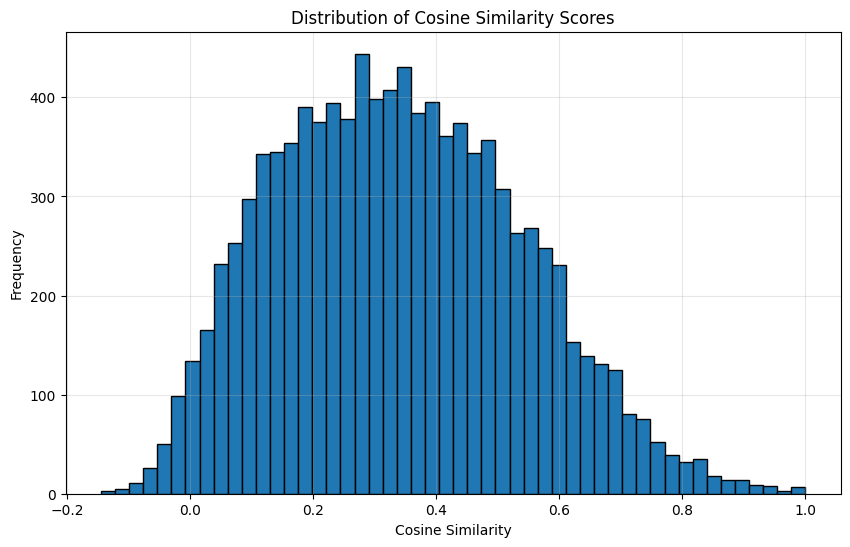

In [17]:
import matplotlib.pyplot as plt

# 获取余弦相似度数据
cos_sim_scores = cosine_scores_2.diagonal()

# 创建直方图
plt.figure(figsize=(10, 6))
plt.hist(cos_sim_scores.cpu().numpy(), bins=50, edgecolor='black')
plt.title('Distribution of Cosine Similarity Scores')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

In [37]:
result_df['cosine_similarity'] = cos_sim_scores.cpu().numpy().tolist()
result_df.head()

,video_name,reference,prediction,cosine_similarity
0,cog-0010fb2b-f6cd-51af-a0b6-b38812f965ea.mp4,The beautiful woman ，under the starry sky ，loo...,a woman with long hair and a white dress,0.249997
1,cog-001777d8-0130-5a50-8792-a6b46e02df6d.mp4,a futuristic city full of robots walking throu...,a robot running on the street,0.488239
2,cog-001e551e-961d-5645-9d84-604bc820bbb7.mp4,computer screen capture of surveillance applic...,The video is shot from the inside of a building.,0.379819
3,cog-001ead14-07ea-592e-bf94-b32c29bd3692.mp4,"las palmeras se mueven, el oc&#233;ano se muev...",light up the palm trees at night,0.119093
4,cog-001fd7f2-1b04-5749-b4cc-0469eae5d144.mp4,"a girl shooting ,in the 1990s moives",a girl with pink flowers in her hair,0.199515


In [38]:
result_df.to_parquet('output/result_df_cosine_similarity.parquet', index=False)

In [4]:
import pandas as pd
result_df = pd.read_parquet('output/result_df_cosine_similarity.parquet')

Test Set Statistics:
Average Cosine Similarity: 0.3355
Max Cosine Similarity: 0.9849
Median Cosine Similarity: 0.3227


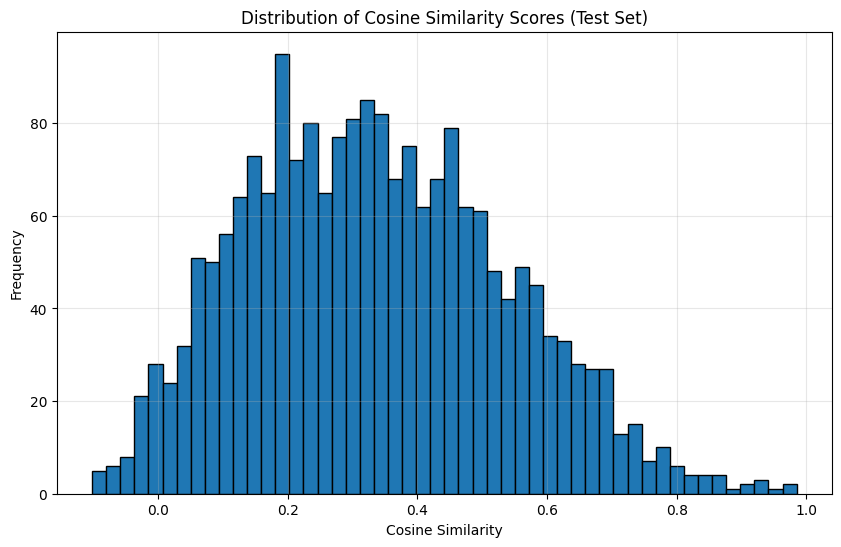

In [6]:
#在result_df中找测试集datasets/test_prompts_20percent.json中对应video_name的行，形成一个新的dataframe
# Read test prompts json file
import json
import matplotlib.pyplot as plt

with open('datasets/test_prompts_20percent.json', 'r') as f:
    test_data = json.load(f)

# Get list of video names from test set
test_video_names = [item['video'] for item in test_data]

# Filter result_df to only include videos from test set
test_result_df = result_df[result_df['video_name'].isin(test_video_names)]

# Print statistics about cosine similarity scores for test set
test_cos_scores = test_result_df['cosine_similarity']
print(f"Test Set Statistics:")
print(f"Average Cosine Similarity: {test_cos_scores.mean():.4f}")
print(f"Max Cosine Similarity: {test_cos_scores.max():.4f}") 
print(f"Median Cosine Similarity: {test_cos_scores.median():.4f}")

# Plot distribution of cosine similarities for test set
plt.figure(figsize=(10,6))
plt.hist(test_cos_scores, bins=50, edgecolor='black')
plt.title('Distribution of Cosine Similarity Scores (Test Set)')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

In [41]:
test_result_df.to_parquet('output/test_result_df_cosine_similarity.parquet', index=False)

In [49]:
test_result_df.reset_index(drop=True, inplace=True)

In [7]:
test_result_df =pd.read_parquet('output/test_result_df_cosine_similarity.parquet')

In [8]:
test_result_df.head()

,video_name,reference,prediction,cosine_similarity
0,cog-001fd7f2-1b04-5749-b4cc-0469eae5d144.mp4,"a girl shooting ,in the 1990s moives",a girl with pink flowers in her hair,0.199515
1,cog-00582ce5-3281-5caa-a751-2e1d80043cb7.mp4,Cinematic surreal portrait of extremely tall a...,a man with a bald head and glasses,0.268857
2,cog-00bba921-d8d5-5a8f-aae2-d985f9cd1649.mp4,"Cinematic, dolly in shot, cute Pixar boy poppi...",a boy in a red shirt is sitting on a box,0.203293
3,cog-00e5d16f-b1d1-51aa-82bf-8a7e4bee3299.mp4,"CLOSE UP SHOT,PHOTOREALISTIC CINEMATIC SHOT OF...",a woman dancing in a white dress in the woods,0.349861
4,cog-01272017-269f-5b42-8458-878ac1228a2e.mp4,intricate fractal patterns pulsating rhythmica...,a blue background with a swirling pattern,0.517504


In [9]:
test_cos_scores

4       0.199515
16      0.268857
26      0.203293
30      0.349861
41      0.517504
          ...   
9979    0.618809
9983    0.426022
9985    0.228738
9986    0.266026
9998    0.632630
Name: cosine_similarity, Length: 2000, dtype: float64

In [16]:
# Get indices where cosine similarity > 0.5
high_test_indices = [i for i, score in enumerate(test_cos_scores) if score > 0.7]

# Create a new dataframe with high similarity pairs
high_test_sim_df = pd.DataFrame({
    'video_name': [test_result_df['video_name'][i] for i in high_test_indices],
    'reference': [test_result_df['reference'][i] for i in high_test_indices],
    'prediction': [test_result_df['prediction'][i] for i in high_test_indices],
    'similarity_score': [test_result_df['cosine_similarity'][i] for i in high_test_indices]
})

# Sort by similarity score in descending order
#high_test_sim_df = high_test_sim_df.sort_values('similarity_score', ascending=False)

print(f"Number of pairs with similarity > 0.7: {len(high_test_sim_df)}")
display(high_test_sim_df.head())

Number of pairs with similarity > 0.7: 74


,video_name,reference,prediction,similarity_score
0,cog-05b523d2-afb9-51c7-8909-e5f42e1ff663.mp4,"a horse running on the beach at sunset, 10 sec.",a horse running on the beach at sunset,0.930937
1,cog-0619814e-a4f4-5ac8-b807-8190ce383644.mp4,Blue alien owl flying through space heading to...,a blue owl flying in the sky,0.787480
2,cog-0707b606-fc70-59b6-997d-6dd7beebf96d.mp4,Missile launching,a rocket launches into the air,0.730328
3,cog-0749ccb3-10c0-5ae9-87e1-66600bf02340.mp4,a lion roaring -m 1,a lion in the wild,0.769626
4,cog-080c79d8-b602-5848-8bb7-cead82986480.mp4,a clocks that goes back in time,time clock,0.781826


In [17]:
import re

def clean_sentence(s):
    s = s.replace("，", ",")  # 替换中文逗号
    s = re.sub(r"-[a-z]+\s*\d+", "", s)  # 去掉如 -fps 24 这种参数
    s = s.strip()
    return s

predictions_test = [p for p in high_test_sim_df['prediction']]
references_test = [[r] for r in high_test_sim_df['reference']]

res_test = Calmetic(references=references_test,predictions=predictions_test)
print(res_test)
print(res_test['BLEU'])
print(res_test['ROUGE']['rougeLsum'][1])


BLEU-1 score: 0.52466
BLEU-2 score: 0.26344
BLEU-3 score: 0.13758
BLEU-4 score: 0.08444
ROUGE-1 F1 score: 0.48405
ROUGE-2 F1 score: 0.22764
ROUGE-L F1 score: 0.45816
ROUGE-Lsum F1 score: 0.45767
Average METEOR score: 0.40313


/home/fenghe/anaconda3/envs/vec2txt/lib/python3.9/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average BERTScore F1: 0.90702
{'BLEU': {'bleu': 0.131034637816354, 'precisions': [0.5246636771300448, 0.26344086021505375, 0.13758389261744966, 0.08444444444444445], 'brevity_penalty': 0.6545765007868669, 'length_ratio': 0.7023622047244095, 'translation_length': 446, 'reference_length': 635}, 'ROUGE': {'rouge1': AggregateScore(low=Score(precision=0.5128258453258453, recall=0.4255961801182389, fmeasure=0.4371958974916215), mid=Score(precision=0.5684726122226123, recall=0.47589989244401004, fmeasure=0.4840476551513784), high=Score(precision=0.6303561069186069, recall=0.5320310779410043, fmeasure=0.5322968110230408)), 'rouge2': AggregateScore(low=Score(precision=0.22020994208494205, recall=0.17130728958315164, fmeasure=0.17862860840802017), mid=Score(precision=0.2813545688545688, recall=0.22023060696361912, fmeasure=0.2276435894082952), high=Score(precision=0.34923182110682116, recall=0.2721137198086361, fmeasure=0.2807756615293379)), 'rougeL': AggregateScore(low=Score(precision=0.4841355

In [18]:
from transformers import BertTokenizer, BertModel
import torch
from torch.nn.functional import cosine_similarity as torch_cosine_similarity
from sentence_transformers import SentenceTransformer, util

sentence_model = SentenceTransformer('all-MiniLM-L6-v2')  #SentenceTransformer("bert-base-uncased") 

embeddings1 = sentence_model.encode(high_test_sim_df['prediction'], convert_to_tensor=True)
embeddings2 = sentence_model.encode(high_test_sim_df['reference'], convert_to_tensor=True)

cosine_scores_2 = util.pytorch_cos_sim(embeddings1, embeddings2)  

# 输出余弦相似度的值
print(f"Average Cosine Similarity: {cosine_scores_2.diagonal().mean()}")
print(f"Biggest Cosine Similarity: {cosine_scores_2.diagonal().max()}")
print(f"Middle Cosine Similarity: {cosine_scores_2.diagonal().median()}")

Average Cosine Similarity: 0.770875871181488
Biggest Cosine Similarity: 0.9849051833152771
Middle Cosine Similarity: 0.7582003474235535


In [59]:
high_test_sim_df.to_parquet('output/high_test_over0.5_sim_df.parquet', index=False)

In [24]:
result_df.head()

,video_name,reference,prediction
0,cog-0010fb2b-f6cd-51af-a0b6-b38812f965ea.mp4,The beautiful woman ，under the starry sky ，loo...,a woman with long hair and a white dress
1,cog-001777d8-0130-5a50-8792-a6b46e02df6d.mp4,a futuristic city full of robots walking throu...,a robot running on the street
2,cog-001e551e-961d-5645-9d84-604bc820bbb7.mp4,computer screen capture of surveillance applic...,The video is shot from the inside of a building.
3,cog-001ead14-07ea-592e-bf94-b32c29bd3692.mp4,"las palmeras se mueven, el oc&#233;ano se muev...",light up the palm trees at night
4,cog-001fd7f2-1b04-5749-b4cc-0469eae5d144.mp4,"a girl shooting ,in the 1990s moives",a girl with pink flowers in her hair


In [25]:
# Get indices where cosine similarity > 0.7
high_sim_indices = (cos_sim_scores > 0.6).nonzero().squeeze().tolist()

# Create a new dataframe with high similarity pairs
high_sim_df = pd.DataFrame({
    'video_name': [result_df['video_name'][i] for i in high_sim_indices],
    'reference': [result_df['reference'][i] for i in high_sim_indices],
    'prediction': [result_df['prediction'][i] for i in high_sim_indices],
    'similarity_score': cos_sim_scores[high_sim_indices].cpu().numpy()
})

# Sort by similarity score in descending order
high_sim_df = high_sim_df.sort_values('similarity_score', ascending=False)

print(f"Number of pairs with similarity > 0.7: {len(high_sim_df)}")
display(high_sim_df.head())

Number of pairs with similarity > 0.7: 1028


,video_name,reference,prediction,similarity_score
66,cog-120e1929-0de0-5cbf-bc77-c16fd10abbda.mp4,A lion standing on a rock,a lion standing on a rock,1.000001
186,cog-2eb99d38-bdd3-5060-958e-c3cfc236ad71.mp4,a yellow umbrella -seed 477881,a yellow umbrella,1.000000
395,cog-5e8a321a-f798-541f-984b-c84ae974c48d.mp4,a woman walking on the beach at sunset,a woman walking on the beach at sunset,1.000000
1013,cog-fc91d84f-9ef0-54aa-b537-5f991f56c35c.mp4,woman standing in front of waterfall,a woman standing in front of a waterfall,0.989053
594,cog-91ea7e61-806b-5c19-95b8-856dd22c9049.mp4,a cat play piano,a cat playing the piano,0.985828


In [26]:
high_sim_df.to_parquet('output/high_sim_over0.6_df.parquet', index=False)

In [27]:
high_sim_df

,video_name,reference,prediction,similarity_score
66,cog-120e1929-0de0-5cbf-bc77-c16fd10abbda.mp4,A lion standing on a rock,a lion standing on a rock,1.000001
186,cog-2eb99d38-bdd3-5060-958e-c3cfc236ad71.mp4,a yellow umbrella -seed 477881,a yellow umbrella,1.000000
395,cog-5e8a321a-f798-541f-984b-c84ae974c48d.mp4,a woman walking on the beach at sunset,a woman walking on the beach at sunset,1.000000
1013,cog-fc91d84f-9ef0-54aa-b537-5f991f56c35c.mp4,woman standing in front of waterfall,a woman standing in front of a waterfall,0.989053
594,cog-91ea7e61-806b-5c19-95b8-856dd22c9049.mp4,a cat play piano,a cat playing the piano,0.985828
...,...,...,...,...
833,cog-cb4c2b68-ea78-5523-813f-9661cdadddc3.mp4,"whitney houston wearing a black gown, with a h...",a woman in a black dress dancing in front of a...,0.600310
680,cog-a22b356d-20f0-54c9-9fdb-64956542c183.mp4,Illustrate a farmer standing with a bag in han...,a man holding a sheep,0.600306
250,cog-3cbbf733-f6e3-5bda-959b-183b19e0551b.mp4,george michael and wham are singing around a c...,man singing and dancing in a Christmas tree,0.600218
344,cog-53b81e89-1377-5b0b-91ea-c7e575b91480.mp4,love coulple see sunsets and crying also,a sunset in the sky,0.600146


In [34]:
import re

def clean_sentence(s):
    s = s.replace("，", ",")  # 替换中文逗号
    s = re.sub(r"-[a-z]+\s*\d+", "", s)  # 去掉如 -fps 24 这种参数
    s = s.strip()
    return s

predictions = [p for p in high_sim_df['prediction']]
references = [[r] for r in high_sim_df['reference']]

res = Calmetic(references=references,predictions=predictions)
print(res['BLEU'])
print(res['ROUGE']['rougeLsum'][1])



BLEU-1 score: 0.45447
BLEU-2 score: 0.16789
BLEU-3 score: 0.06962
BLEU-4 score: 0.02857
ROUGE-1 F1 score: 0.39470
ROUGE-2 F1 score: 0.15023
ROUGE-L F1 score: 0.36395
ROUGE-Lsum F1 score: 0.36408
Average METEOR score: 0.30135


/home/fenghe/anaconda3/envs/vec2txt/lib/python3.9/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average BERTScore F1: 0.89435
{'bleu': 0.04604888421847928, 'precisions': [0.4544704264099037, 0.16789490547901315, 0.06962025316455696, 0.02857142857142857], 'brevity_penalty': 0.4148742082005946, 'length_ratio': 0.5319771696180301, 'translation_length': 7270, 'reference_length': 13666}
Score(precision=0.4653732101557565, recall=0.3548934141151914, fmeasure=0.3640773315796495)


In [ ]:
from transformers import BertTokenizer, BertModel
import torch
from torch.nn.functional import cosine_similarity as torch_cosine_similarity
from sentence_transformers import SentenceTransformer, util

sentence_model = SentenceTransformer('all-MiniLM-L6-v2')  #SentenceTransformer("bert-base-uncased") 

embeddings1 = sentence_model.encode(high_sim_df['prediction'], convert_to_tensor=True)
embeddings2 = sentence_model.encode(high_sim_df['reference'], convert_to_tensor=True)

cosine_scores_2 = util.pytorch_cos_sim(embeddings1, embeddings2)  

# 输出余弦相似度的值
print(f"Average Cosine Similarity: {cosine_scores_2.diagonal().mean()}")
print(f"Biggest Cosine Similarity: {cosine_scores_2.diagonal().max()}")
print(f"Middle Cosine Similarity: {cosine_scores_2.diagonal().median()}")

/home/fenghe/anaconda3/envs/vec2txt/lib/python3.9/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Average Cosine Similarity: 0.6907076835632324
Biggest Cosine Similarity: 1.000000238418579
Middle Cosine Similarity: 0.6720725297927856
